# TensorFlow Time Series Forecasting 

- visualizing Time Series w/ matplotlib
- Preprocessing time series data 
- Creating custom callbacks 
- Building LSTM based time series forecasting models 
- Building Convolution-layer based time series forecasting models 
- Building mixed architecture models 
- Evaluating time series forecast predictions 


Dataset used comes from the air quality sensors acrsoss South Korea. The snesors measure and record all types of air pollutants/particles in the air. 
Will focus only on $PM_{2.5}$ (fine dust)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 

print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  2.12.0


In [2]:
pollution = pd.read_csv("/kaggle/input/south-korean-pollution/south-korean-pollution-data.csv",
                       parse_dates = ['date'],
                       index_col = 'date')
# Filter for only PM25 in Jeongnim-Dong City, sorted by date 
pollution = pollution[pollution.City == 'Jeongnim-Dong'].pm25.sort_index()
# starts the dataset at 2018 and ends in 2022 since breaks in data 
start = pd.to_datetime('2018-01-01')
end = pd.to_datetime('2022-01-01')
pollution = pollution[start:end]
pollution.head()

date
2018-01-01    72
2018-01-02    95
2018-01-03    57
2018-01-04    70
2018-01-05    88
Name: pm25, dtype: int64

### Impute Missing Dates 

Time series data is sensitive to missing values, so need to impute missing time

In [3]:
# Checks for and imputes missing dates 
a = pd.date_range(start=start,end=end, freq = "D")
b = pollution.index

diff_dates = a.difference(b)

td = pd.Timedelta(1, "d")
for date in diff_dates:
    prev_val = pollution[date-td]
    pollution[date] = prev_val

    
pollution.sort_index(inplace = True)

pollution.freq = "D"

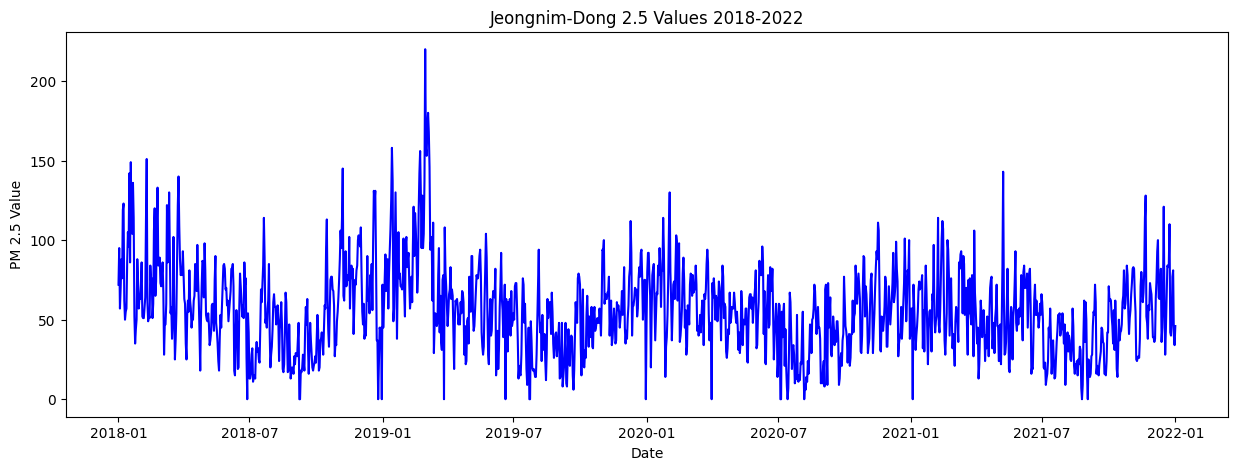

In [4]:
fig = plt.figure(figsize=(15,5))
plt.plot(pollution, color = 'blue')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Jeongnim-Dong 2.5 Values 2018-2022')
plt.show()

### Split Dataset into Train and Test

In [5]:
end_train_idx = pd.to_datetime('2020-12-31')
train = pollution[:end_train_idx]
test = pollution[end_train_idx:]

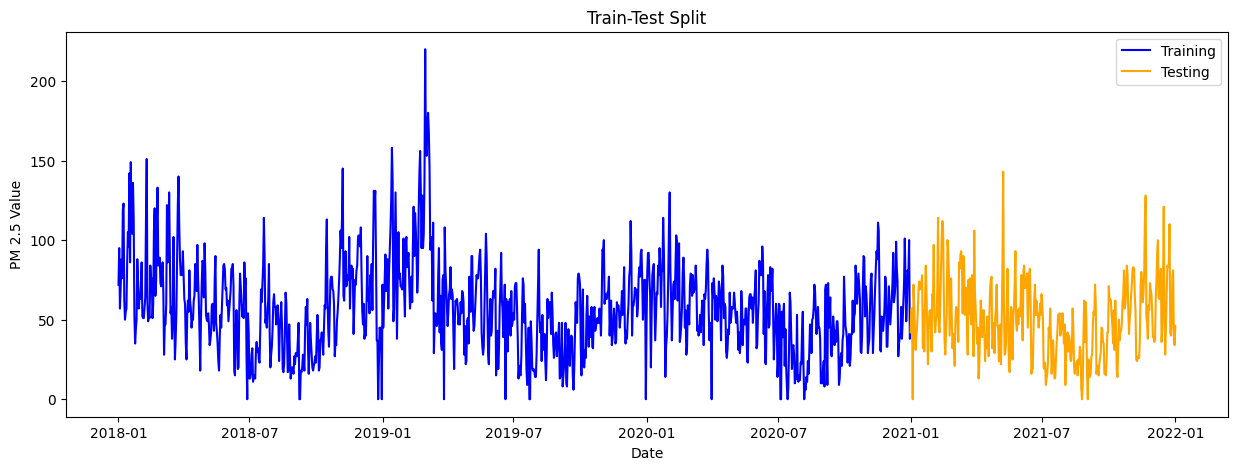

In [6]:
fig = plt.figure(figsize=(15,5))
plt.plot(train, color = 'blue', label = 'Training')
plt.plot(test, color = 'orange', label = 'Testing')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title("Train-Test Split")
plt.legend()
plt.show()

### Process Dataset with Windows 

Time series data needs to be sliced into windows before being processed by ML models. A window is essentially a limited snapshot of the data

In [7]:
# Creates a windowed dataset from the time-series data 
WINDOW = 14 # 14 days 

# Converts values to TensorSlideDataset
train_data = tf.data.Dataset.from_tensor_slices(train.values)

# Takes window size + 1 slices of the dataset
train_data = train_data.window(WINDOW+1, shift = 1, drop_remainder = True)

# flattens windowed data by batching 
train_data = train_data.flat_map(lambda x: x.batch(WINDOW+1))

# creates features and target tuple 
train_data = train_data.map(lambda x: (x[:-1], x[-1]))

# shuffles dataset 
train_data = train_data.shuffle(1_000)

# creates batches of windows 
train_data = train_data.batch(32).prefetch(1)

The `train_data` has batches of windowed time series data. the batches are filled with arrays of 14 pm25 values and their target values.

#### Custom Callback

Callbacks are used in Tensorflow to allow user intervention during model training. A callback can be executed at a number of specific instances during model training. 
- `on_batch_begin`/`end`
- `on_epoch_begin`/`end`
- `on_predict_batch_begin`/`end`
- `on_predict_begin`/`end`
- `on_test_batch_begin`/`end`
- `on_test_begin`/`end`
- `on_train_batch_begin`/`end`
- `on_train_begin`/`end`

The `CustomCallback` will be used to stop model training once the model reaches < 10 MAE on the training set.

In [9]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 10.0:
            print("MAE under 10.0 ... Stopping Training")
            self.model.stop_training = True

my_callback = CustomCallback()

### Predefined Callback - `LearningRateScheduler`



In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler

# creates a function that updates the learning rate based on the epoch number 
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

### LSTM Model

LSTM (Long Short-Term Memory) layers are sequence aware and can carry meaning from previous time steps. These layers are commonly used in all machine learning task where order is important -- to include time series forecasting. 

**Pros:**
- Can retain information from far in the past to make its prediction
- Proven to be highly effective 

**Cons:**
- Many parameters 
- Long training time 

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

lstm_model = Sequential([
    # add extra axis to input data 
    Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape=[WINDOW]),
    Bidirectional(LSTM(128, return_sequences = True)),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

lstm_model.compile(
    loss = Huber(),
    optimizer = Adam(),
    metrics = ['mae']
)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 14, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 14, 256)          133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [16]:
# Trains LSTM Model

lstm_history = lstm_model.fit(
train_data,
epochs = 100,
callbacks=[lr_scheduler, my_callback],
verbose = 0)

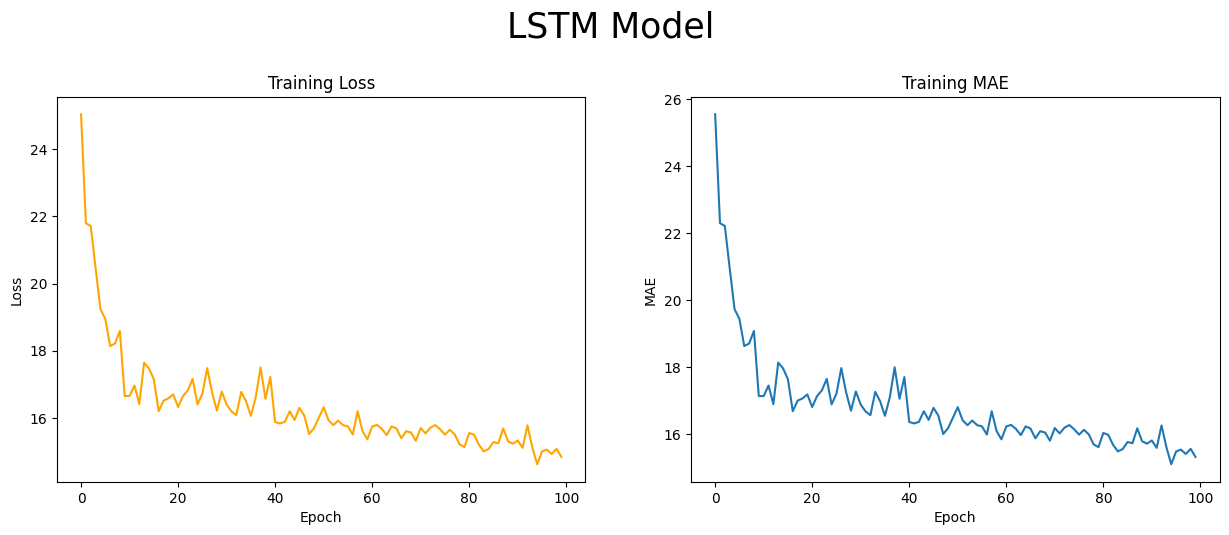

						 Final Loss: 14.83 | Final MAE: 15.33


In [17]:
# Plots training history 
# plot history of model training 

#plt.rcParams['figure.figsize'] = (15,5)
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(lstm_history.history['loss'], color = 'orange')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title("Training Loss")

axs[1].plot(lstm_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title("Training MAE")

fig.text(0.425, 1, "LSTM Model", {'size':25})
plt.show()

print(f"\t\t\t\t\t\t Final Loss: {round(lstm_history.history['loss'][-1], 2)} | Final MAE: {round(lstm_history.history['mae'][-1], 2)}")

### Convolution Model 

2D convolution layers are used in Computer Vision. Their 1D version can be used for time series data. 1D convolution layer tries to find patterns in different segments of the time series data. 

**Pros:**
- Low parameters
- Fast training time

**Cons:**
- Tends to put more weight on recent values 


In [22]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Flatten

cnn_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape=[WINDOW]),
    Conv1D(filters = 32, kernel_size = 3, strides=1, 
          padding='causal', activation='relu'),
    Conv1D(filters = 64, kernel_size = 3, strides = 1,
          padding = 'causal', activation = 'relu'),
    GlobalAveragePooling1D(),
    Flatten(),
    Dropout(0.3),
    Dense(512, activation = 'relu'),
    Dropout(0.4),
    Dense(1)
])

cnn_model.compile(
    loss = Huber(),
    optimizer = Adam(),
    metrics=['mae']
)

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 14, 32)            128       
                                                                 
 conv1d_4 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

In [23]:
# Train CNN Model
cnn_history = cnn_model.fit(
    train_data,
    epochs = 100,
    callbacks=[lr_scheduler, my_callback],
    verbose = 0
)

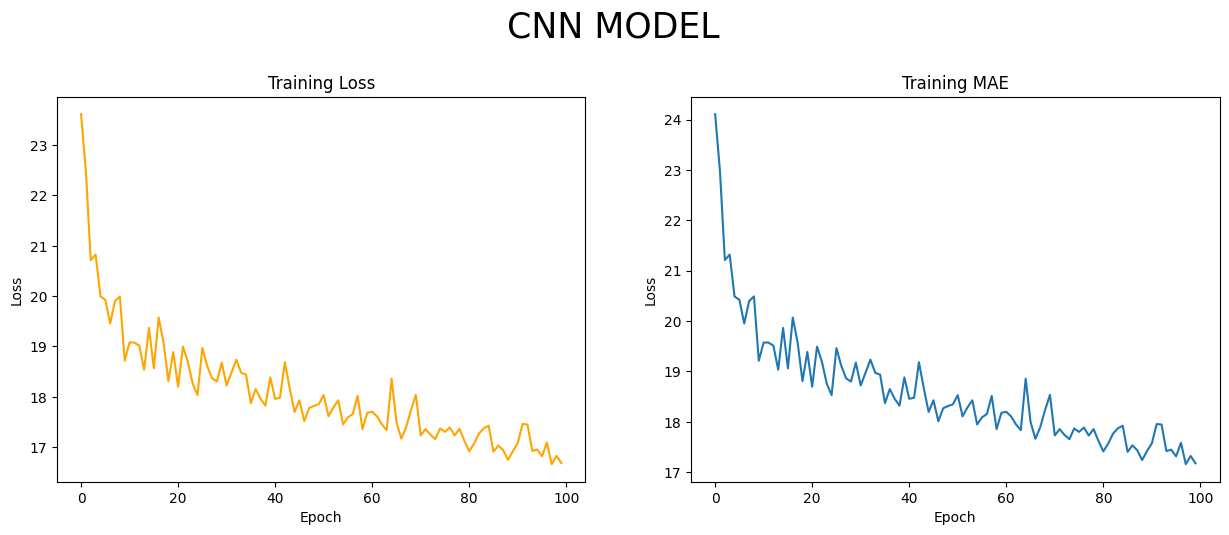

In [24]:
# Plots training history of model training 

fig, axs = plt.subplots(1,2, figsize = (15,5))

axs[0].plot(cnn_history.history['loss'], color = 'orange')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")

axs[1].plot(cnn_history.history['mae'])
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_title("Training MAE")

fig.text(0.425, 1, "CNN MODEL", {'size':25})
plt.show()

In [29]:
print(f"FINAL LOSS: {round(cnn_history.history['loss'][-1], 2)} | FINAL MAE: {round(cnn_history.history['mae'][-1], 2)}")

FINAL LOSS: 16.68 | FINAL MAE: 17.18


### Mixed Architecture Model 
Best of both worlds by mixing the Convolution layers with the LSTM layers

In [26]:
mixed_model = Sequential([
    # add extra axis to input data 
    Lambda(lambda x: tf.expand_dims(x, axis = 1), input_shape = [WINDOW]),
    Conv1D(filters = 64, kernel_size = 3, strides = 1,
          padding = 'causal', activation='relu'),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(512, activation = 'relu'),
    Dropout(0.4),
    Dense(1)
])

mixed_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

mixed_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_7 (Lambda)           (None, 1, 14)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             2752      
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 256)           197632    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)              

In [27]:
# Trains Mixed Model
mixed_history = mixed_model.fit(
    train_data,
    epochs = 100,
    callbacks=[lr_scheduler, my_callback],
    verbose = 0
)

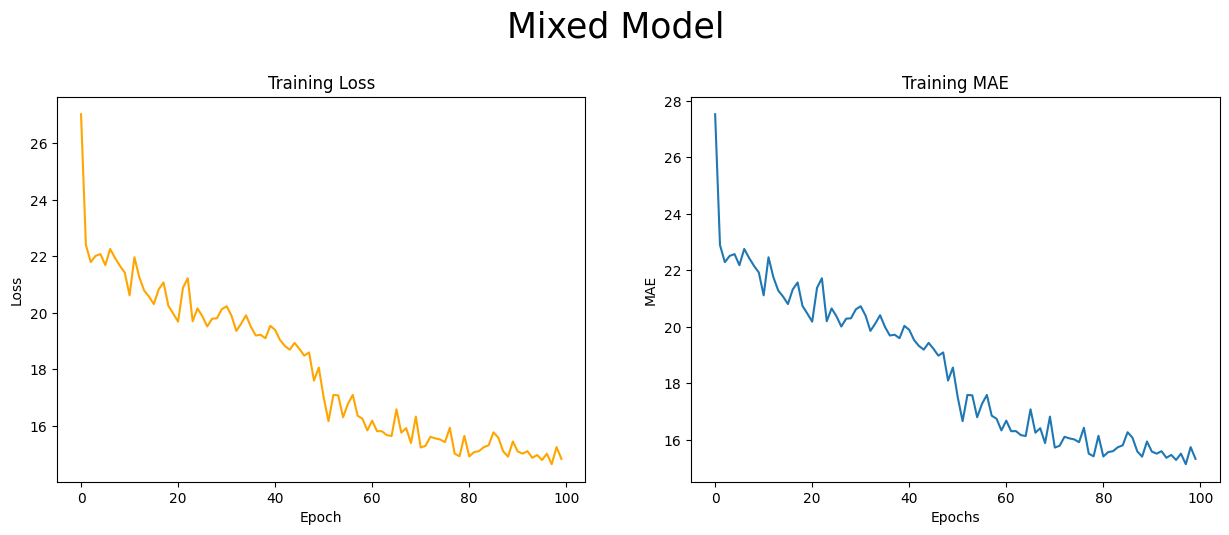

In [30]:
# plots training history of the model training 

fig, axs = plt.subplots(1,2, figsize = (15,5))

axs[0].plot(mixed_history.history['loss'], color = 'orange')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")

axs[1].plot(mixed_history.history['mae'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("MAE")
axs[1].set_title("Training MAE")

fig.text(0.425,1,'Mixed Model', {'size':25})
plt.show()


In [31]:
print(f"\t\t\t\t\t Final Loss: {round(mixed_history.history['loss'][-1], 2)} | Final MAE: {round(mixed_model.history['mae'][-1], 2)}")

TypeError: 'History' object is not subscriptable

### Evaluate Models on Test Set

In [47]:
all_models = [('LSTM MODEL', lstm_model),
              ("CNN MODEL", cnn_model),
             ("MIXED MODEL", mixed_model)]

model_forecasts = {
    'LSTM MODEL': [],
    'CNN MODEL' : [],
    'MIXED MODEL': [],
}

# chunk of data to windowed s othat each window associated to a vlue in test set
forecast_data = train[-WINDOW:]._append(test[:-1]).values

for name, model in all_models:
    # converts values to TensorSliceDatasest
    test_data = tf.data.Dataset.from_tensor_slices(forecast_data)
    # takes window size slices of the dataset 
    test_data = test_data.window(WINDOW, shift = 1, drop_remainder=True)
    # flattens windowed data by batching 
    test_data = test_data.flat_map(lambda x: x.batch(WINDOW+1))
    # creates batches of windows
    test_data = test_data.batch(32).prefetch(1)
    # gets model prediction 
    preds = model.predict(test_data)
    # append to forecast dict
    model_forecasts[name].append(preds)

12/12 [==============================] - 2s 10ms/step


In [49]:
# Gets MAE Score of model forecasts 
N = test.values.shape[0] # Number of samples in test set

lstm_mae = np.abs(test.values - model_forecasts['LSTM MODEL'][0].squeeze()).sum() / N

cnn_mae = np.abs(test.values - model_forecasts['CNN MODEL'][0].squeeze()).sum() / N

mix_mae = np.abs(test.values - model_forecasts['MIXED MODEL'][0].squeeze()).sum() / N

print("MODEL MAE SCORES \n", 25*"-")
print("LSTM MAE: ", round(lstm_mae, 2))
print("CNN MAE: ", round(cnn_mae, 2))
print("MIXED MAE: ", round(mix_mae, 2))

MODEL MAE SCORES 
 -------------------------
LSTM MAE:  14.43
CNN MAE:  17.55
MIXED MAE:  14.22


###### Note: the best ML Models achieve around 13 MAE score for this problem

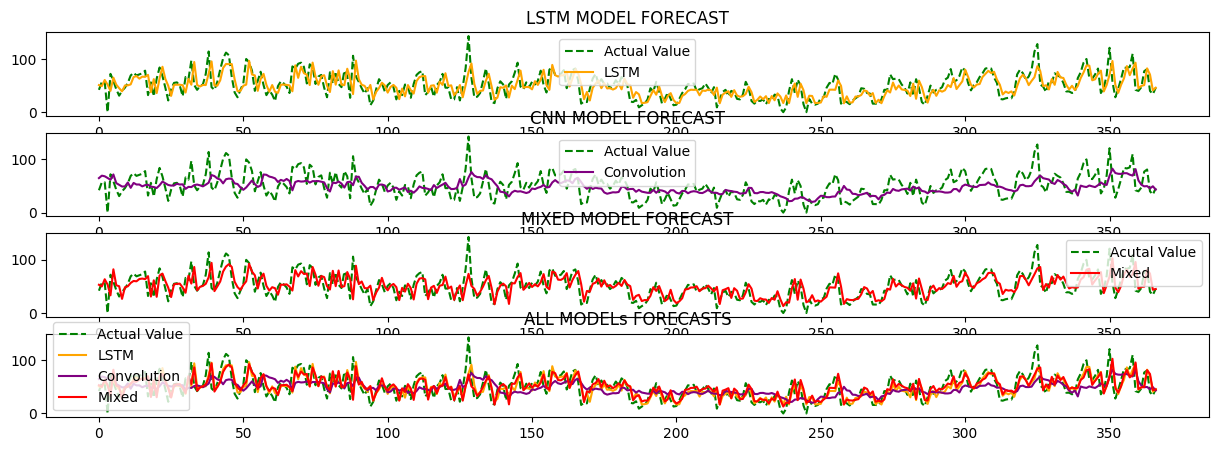

In [50]:
# displays forecasted data 

fig, axs = plt.subplots(4,1, figsize = (15,5))

# LSTM Forecast
axs[0].plot(test.values, color = 'green', linestyle='--', label='Actual Value')
axs[0].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='orange',label = "LSTM")
axs[0].set_title("LSTM MODEL FORECAST")
axs[0].legend()

# CNN Forecast
axs[1].plot(test.values, color = 'green', linestyle='--', label = 'Actual Value')
axs[1].plot(model_forecasts['CNN MODEL'][0].squeeze(), color = 'purple', label = 'Convolution')
axs[1].set_title("CNN MODEL FORECAST")
axs[1].legend()

# MIXED MODEL FORECAST
axs[2].plot(test.values, color = 'green', linestyle='--', label = 'Acutal Value')
axs[2].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color = 'red', label = 'Mixed')
axs[2].set_title("MIXED MODEL FORECAST")
axs[2].legend()

# ALL Forecasts
axs[3].plot(test.values, color = 'green', linestyle = '--', label = 'Actual Value')
axs[3].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color = 'orange', label = 'LSTM')
axs[3].plot(model_forecasts['CNN MODEL'][0].squeeze(), color = 'purple', label = "Convolution")
axs[3].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color = 'red', label = "Mixed")
axs[3].set_title("ALL MODELs FORECASTS")
axs[3].legend()

plt.tight_layout(pad = 4)
plt.show()